In [1]:
!pip install -U datasets rouge-score sentencepiece


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.8 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6b3f36e371b1867c70e06fddcc90da83e7b0b62f1ac824cc187d271faa8d5ab8
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import Dataset
from rouge_score import rouge_scorer
import os
from tqdm import tqdm
import numpy as np

In [3]:
# Step 1: Load dataset & sample
# ------------------------------
df = pd.read_parquet("Khmer_Data.parquet")
sampled_df = df.sample(n=3000, random_state=123)
hf_dataset = Dataset.from_pandas(sampled_df)

In [4]:
# Step 2: Split train/validation
# ------------------------------
split = hf_dataset.train_test_split(test_size=0.2, seed=123)
train_data = split['train']
val_data = split['test']

In [5]:
# Step 3: Load MBart model & tokenizer
# ------------------------------
model_dir = "./khmer_summarizer_model"
model_name = "facebook/mbart-large-50-many-to-many-mmt"

tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
tokenizer.src_lang = "km_KH"
tokenizer.tgt_lang = "km_KH"

if os.path.exists(model_dir):
    print("Loading previously saved model...")
    model = MBartForConditionalGeneration.from_pretrained(model_dir)
else:
    model = MBartForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [6]:
# ------------------------------
# Step 4: Tokenization function
# ------------------------------
max_input_len = 256
max_output_len = 128

def tokenize_batch(batch):
    src = tokenizer(batch['full_article'], truncation=True, padding=False, max_length=max_input_len)
    tgt = tokenizer(batch['summary'], truncation=True, padding=False, max_length=max_output_len)
    batch['input_ids'] = src['input_ids']
    batch['attention_mask'] = src['attention_mask']
    batch['labels'] = tgt['input_ids']
    return batch

train_data = train_data.map(tokenize_batch, batched=True)
val_data = val_data.map(tokenize_batch, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [7]:
# Step 5: DataLoader with dynamic padding
# ------------------------------
def batch_pad(batch):
    input_ids = pad_sequence([torch.tensor(x['input_ids']) for x in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([torch.tensor(x['attention_mask']) for x in batch], batch_first=True, padding_value=0)
    labels = pad_sequence([torch.tensor(x['labels']) for x in batch], batch_first=True, padding_value=-100)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=batch_pad)
val_loader = DataLoader(val_data, batch_size=4, collate_fn=batch_pad)

In [8]:
# Step 6: Setup device & optimizer
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [9]:
# Step 7: ROUGE setup
# ------------------------------
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

def rouge_avg(predictions, references):
    r1 = np.mean([rouge.score(r, p)['rouge1'].fmeasure for r, p in zip(references, predictions)])
    r2 = np.mean([rouge.score(r, p)['rouge2'].fmeasure for r, p in zip(references, predictions)])
    rL = np.mean([rouge.score(r, p)['rougeL'].fmeasure for r, p in zip(references, predictions)])
    return {"rouge1": r1, "rouge2": r2, "rougeL": rL}

In [10]:
num_epochs = 10
patience = 3                 # Stop if validation loss doesn't improve for 2 epochs
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []

for ep in range(num_epochs):
    # ---------- Training ----------
    model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {ep+1} Training"):
        optimizer.zero_grad()
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        outputs = model(input_ids=batch_input_ids,
                        attention_mask=batch_attention,
                        labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------- Validation ----------
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch_input_ids = batch['input_ids'].to(device)
            batch_attention = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=batch_input_ids,
                            attention_mask=batch_attention,
                            labels=batch_labels)
            val_running_loss += outputs.loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {ep+1}/{num_epochs} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # ---------- Early Stopping ----------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save best model
        os.makedirs(model_dir, exist_ok=True)
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)
        print("Validation improved. Model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("Early stopping triggered. Training stopped.")
            break

Epoch 1 Training: 100%|██████████| 600/600 [09:21<00:00,  1.07it/s]


Epoch 1/10 -> Train Loss: 3.1338, Val Loss: 2.7545


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Validation improved. Model saved.


Epoch 2 Training: 100%|██████████| 600/600 [09:22<00:00,  1.07it/s]


Epoch 2/10 -> Train Loss: 2.4522, Val Loss: 2.6063
Validation improved. Model saved.


Epoch 3 Training: 100%|██████████| 600/600 [09:23<00:00,  1.07it/s]


Epoch 3/10 -> Train Loss: 2.0783, Val Loss: 2.5448
Validation improved. Model saved.


Epoch 4 Training: 100%|██████████| 600/600 [09:22<00:00,  1.07it/s]


Epoch 4/10 -> Train Loss: 1.7682, Val Loss: 2.5529
No improvement in validation for 1 epoch(s).


Epoch 5 Training: 100%|██████████| 600/600 [09:22<00:00,  1.07it/s]


Epoch 5/10 -> Train Loss: 1.4968, Val Loss: 2.5903
No improvement in validation for 2 epoch(s).


Epoch 6 Training: 100%|██████████| 600/600 [09:22<00:00,  1.07it/s]


Epoch 6/10 -> Train Loss: 1.2527, Val Loss: 2.6762
No improvement in validation for 3 epoch(s).
Early stopping triggered. Training stopped.


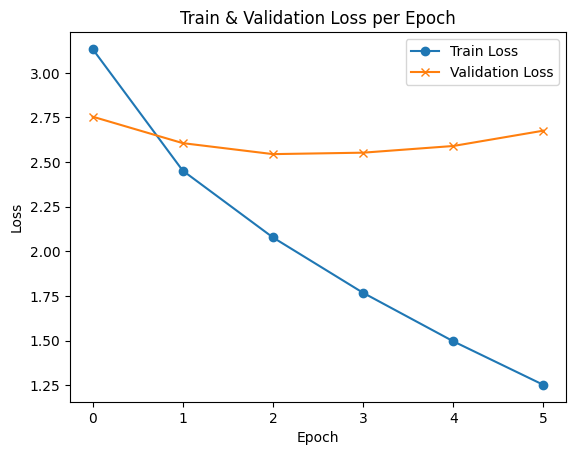

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss per Epoch')
plt.legend()
plt.show()

In [17]:
# Step 9: Evaluate first 20 validation articles and show full article
# ------------------------------
model.eval()
num_samples = 20  # first 20 validation articles
test_samples = val_data.select(range(num_samples))

# Extract texts and references
test_texts = [x['full_article'] for x in test_samples]
test_refs  = [x['summary'] for x in test_samples]

# Tokenize
tokenized_input = tokenizer(
    test_texts,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=max_input_len
)
tokenized_input = {k: v.to(device) for k, v in tokenized_input.items()}

# Generate summaries
with torch.no_grad():
    generated_ids = model.generate(
        **tokenized_input,
        max_length=max_output_len,
        num_beams=4,          # better quality
        early_stopping=True
    )

pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

# Initialize ROUGE scorer
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

# Print full article + reference + prediction + ROUGE
for i, (article, ref, pred) in enumerate(zip(test_texts, test_refs, pred_texts)):
    score = scorer.score(ref, pred)

    print(f"\n--- Article {i+1} ---")
    print("Full Article:\n", article)
    print("\nReference Summary:\n", ref)
    print("\nPredicted Summary:\n", pred)
    print("\nROUGE-1:", round(score['rouge1'].fmeasure, 4))
    print("ROUGE-2:", round(score['rouge2'].fmeasure, 4))
    print("ROUGE-L:", round(score['rougeL'].fmeasure, 4))
    print("-" * 100)



--- Article 1 ---
Full Article:
 ក្រុម​អ្នកឯកទេស​សុខភាព​បា​ន​ណែនាំ​ថា ត្រូវ​ឈរ​យ៉ាងតិច​ឲ្យ​បាន​ពីរ​ម៉ោង​ក្នុង​មួយថ្ងៃ នៅ​អំឡុងពេល​ធ្វើការ។ បើ​យក​ល្អ គឺ​គួរតែ​ឈរ​ឲ្យ​បាន​បួន​ម៉ោង។ មានន័យថា បុគ្គលិក​ទាំងឡាយ​គួរតែ​ឧស្សាហ៍​ក្រោកឈរ​ឲ្យ​បាន​ទៀងទាត់ ហើយ​ការចាកចេញ​ពី​កៅអី​នេះ​អាច​គណនា​ស្មើនឹង​រយៈពេល​ពីរ​ម៉ោង។ ការ​អង្គុយ​យូរពេក​នាំ​ឲ្យ​ប្រឈមមុខ​កាន់តែខ្លាំង​នឹង​ការកើត​ជំងឺ​រ៉ាំរ៉ៃ​ដូចជា ទឹកនោមផ្អែម ដុះ​ក្បាលពោះ និង​ជំងឺ​បេះដូង​ជាដើម។ អ្នកឯកទេស​ម្នាក់​បាន​និយាយថា បើ​អង្គុយ​កាន់តែ​យូរ អាយុ​កាន់តែ​ខោ​ច។ បើតាម​ទិន្នន័យ អ្នកធ្វើការ​ការិយាល័យ​អង្គុយ​នៅ​ស្ងៀម​យ៉ាងហោចណាស់​ក៏ ៣០ នាទី​ដែរ​ទើប​ងើប​ចេញ​ម្តង។ តាមពិតទៅ ជា​រៀងរាល់​ម៉ោង យើង​អាច​ក្រោកឈរ​ប៉ុន្មាន​នាទី ដោយ​ការដើរ​ទៅរក​កាហ្វេ ឬ​បន្ទប់ទឹក​ជាដើម។ ម្យ៉ាងទៀត យើង​គួរតែ​ចាប់យក​ទម្លាប់​ឈរ​និយាយ​ទូរស័ព្ទ ឬ​ដើរ​ទៅរក​មិត្ត​រួមការ​ងារ​ដើម្បី​ប្រាប់​ពី​ព័ត៌មានផ្សេងៗ ជំនួស​ឲ្យ​ការផ្ញើ​អ៊ី​ម៉ែ​ល។ នេះ​ជា​វិធីងាយៗដែល​យើង​អាចអនុវត្ត​បាន​នៅ​កន្លែងធ្វើការ៕ អ្នកសរសេរអត្ថបទ សូមចុចត្រង់នេះដើម្បីអានថ្មីៗជាភាសាអង់គ្លេស (Cambodianess.com)

Reference Summary:
 ជាទូទៅ​បុគ្

In [15]:
text = "រដ្ឋមន្ត្រីទទួលបន្ទុករដ្ឋលេខាធិការដ្ឋានអាកាសចរណ៍ស៊ីវិល(SSCA) លោក ម៉ៅ ហាវណ្ណាល់ បាន​ចាត់​ទុកថា ការ​សម្រេច​របស់​ថ្នាក់ដឹក​នាំ​ក្រុមហ៊ុនអាកាសចរណ៍ជាតិ អ៊ែរ ខេមបូឌា (Air Cambodia/ K6) ដែល​បញ្ជាទិញ​យន្តហោះ Boeing 737 MAX ចំនួន ១០ គ្រឿងជាផ្លូវការពី​ក្រុមហ៊ុន​ផលិតយន្តហោះ​ឈានមុខ​គេ​របស់​អាមេរិក Boeing នឹងនាំមកនូវសារៈប្រយោជន៍ជាយុទ្ធសាស្ត្រជា​ច្រើន​សម្រាប់​កម្ពុជា ព្រម​ទាំង​បង្ហាញពីទំនាក់ទំនងសេដ្ឋកិច្ច​ដែល​កាន់​តែ​ល្អ​ប្រសើរ​រវាង​ប្រទេស​ទាំង ២ ផងដែរ​។តាម​ផែនការ Boeing 737 MAX នឹងត្រូវដាក់ឱ្យប្រើប្រាស់នៅកម្ពុជាចាប់​ពីឆ្នាំ២០៣១ ខាងមុខតទៅ​។រដ្ឋលេខាធិការ និងជាអ្នកនាំពាក្យ​នៃរដ្ឋលេខាធិការដ្ឋានអាកាសចរណ៍ស៊ីវិល លោក ស៊ីន ចាន់សិរីវុត្ថា បាន​ប្រាប់​ភ្នំពេញ​ប៉ុស្តិ៍​​ក្នុង​ថ្ងៃ​ទី​១៣ ខែមករា ថា ដើម្បី​ជំរុញ​កិច្ច​សហប្រតិបត្តិការរវាង​រដ្ឋាភិបាល​កម្ពុជា និង​ផ្នែកឯកជន​អាមេរិក កាល​ពី​ថ្ងៃទី៥-៩ ខែមករា ឆ្នាំ២០២៦ លោក ម៉ៅ ហាវណ្ណាល់ អមដោយមន្ត្រីជំនាញជាន់ខ្ពស់នៃរដ្ឋលេខាធិការដ្ឋានអាកាសចរណ៍ស៊ីវិល និងថ្នាក់​ដឹកនាំ​​ក្រុមហ៊ុន Air Cambodia/ K6 បានទៅធ្វើ​ទស្សនកិច្ចផ្លូវការ​ដើម្បី​ស្វែងយល់ពីក្រុមហ៊ុនផលិតយន្តហោះ Boeing នៅក្នុង​ទីក្រុង Seattle សហរដ្ឋអាមេរិក។"

inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    max_length=512
).to(device)

with torch.no_grad():
    summary_ids = model.generate(
        **inputs,
        max_length=200,
        num_beams=4,
        early_stopping=True
    )

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)


ភ្នំពេញ៖ រដ្ឋាភិបាល កម្ពុជា និងរដ្ឋលេខាធិការដ្ឋានអាកាសចរណ៍ស៊ីវិល(SSCA) សម្រេចដាក់យន្តហោះ Boeing 737 MAX ចំនួន ១០ គ្រឿងជាផ្លូវការ។នេះ បើតាមការប្រកាសរបស់រដ្ឋលេខាធិការដ្ឋានអាកាសចរណ៍ស៊ីវិល។


In [16]:
text = "ប្រទេស​​ចិន​បានដើរ​តួនាទី​​ជា​មជ្ឈមណ្ឌល​​ផ្គត់ផ្គង់​ទំនិញ​កាន់​តែ​​​សំខាន់​សម្រាប់ប្រទេស​កម្ពុជា ដោយ​ក្នុង​ឆ្នាំ​២០២៥ កន្លង​មក​ទំនិញ​ដែល​ប្រទេស​ចិន​នាំចូលកម្ពុជា​ មាន​ទឹក​ប្រាក់​​ជាង ១៨​ ពាន់​លាន​ដុល្លារ កើន​ជាង ៣០​% ​បើ​ធៀប​នឹង​ឆ្នាំ​២០២៤។ ប្រាក់​ដែល​កម្ពុជា​​បញ្ចេញ​សម្រាប់នាំចូល​​​ទំនិញ​ពី​ប្រទេសចិន​បាន​គ្រប​ដណ្តប់​លើស ៥០% នៃ​ចំនួន​ទឹក​ប្រាក់​សរុប​ដែល​កម្ពុជា​​បញ្ចេញ​សម្រាប់​​នាំចូល​ទំនិញ​ពី​ប្រទេសដៃគូ​ពាណិជ្ជកម្ម​ទាំង​អស់​។​យោង​តាម​របាយការណ៍​របស់​​​អគ្គនាយក​ដ្ឋាន​គយ និង​រដ្ឋាករ​កម្ពុជា​(GDCE) ក្នុង​ឆ្នាំ ២០២៥ កម្ពុជា​បាន​បញ្ចេញ​ប្រាក់​សរុប​ ៣៣,៨៨ ពាន់​លាន​ដុល្លារ​ទៅ​លើ​ការ​នាំចូលទំនិញ​ពី​គ្រប់​ប្រទេស​ទាំង​អស់​លើ​ពិភពលោក ដោយ​កើន​ឡើង​ ១៨,៧%​ បើ​ធៀប​នឹង​ឆ្នាំ​២០២៤ ដែល​មាន ២៨,៥៤ ពាន់​លាន​ដុល្លារ​។ ក្នុងនោះ​​​ទំនិញ​នាំចូល​ពី​ប្រទេស​ចិន​មាន​ទឹក​ប្រាក់ ១៨,០៤ ពាន់លាន​ដុល្លារ កើន​ឡើង ៣៤,៣% ពី​ចំនួន ១៣,៤៣ ពាន់​លាន​ដុល្លារ​។ ទឹក​ប្រាក់ទិញ​ទំនិញ​ពី​ប្រទេស​ចិន​ស្មើ​នឹង ៥៣,២៥% នៃ​ចំនួន​ទឹក​ប្រាក់សរុប​ដែល​កម្ពុជា​បញ្ចេញ​សម្រាប់​​នាំ​ចូល​ទំនិញ​ពី​គ្រប់​ប្រទេស​ទាំង​អស់​។​"
inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    max_length=512
).to(device)

with torch.no_grad():
    summary_ids = model.generate(
        **inputs,
        max_length=200,
        num_beams=4,
        early_stopping=True
    )

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)


កម្ពុជា បាន បញ្ចេញ ទឹក ប្រាក់ សរុប ចំនួន ៣៣,៨៨ ពាន់ លាន ដុល្លារ ទៅ លើ ការ នាំចូល ទំនិញ ពី គ្រប់ ប្រទេស ទាំង អស់ លើ ពិភពលោក ក្នុង ឆ្នាំ ២០២៥ ។ នេះ បើតាម របាយការណ៍ របស់ អគ្គនាយក ដ្ឋាន គយ និង រដ្ឋាករ កម្ពុជា ។
